# 06_1 Klassifitseerimismudelid - logistiline regressioon

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
data = pd.read_excel('toofailid/DATA_TEKSTIKOGU_puhastatud.xlsx', engine='openpyxl')
print(data.shape)

(636, 55)


In [8]:
sagedused = data['Lahendi liik'].value_counts()

In [9]:
sagedused

õigeksmõistev    350
tauniv           286
Name: Lahendi liik, dtype: int64

In [10]:
# Andmestiku segamine
#from sklearn.utils import shuffle
#data = shuffle(data)
#data = data.reset_index(drop=True)

In [11]:
# Ebavajaliku info  (aeg, pealkiri) eemaldamine
#data.drop(["date"],axis=1,inplace=True)
#data.drop(["title"],axis=1,inplace=True)
#data.drop(["subject"],axis=1,inplace=True)
#data.drop(["link"],axis=1,inplace=True)

In [12]:
#tekst_puhas = data['text_puhas'].to_list()
#tekst_tokenize = data['text_token'].to_list()
#tekst_lemmatize = data['text_lemmatize'].to_list()
#label = data['Lahendi liik'].to_list()

Stoppsõnadena on kasutusel sidesõnad ja sidesõnad koos asesõnadega.

In [13]:
#https://et.wikipedia.org/wiki/Sides%C3%B5na
#https://www.taskutark.ee/m/asesonad/
#sidesõnad
stopsõnad = ['ja', 'ning', 'ega', 'ehk', 'või', 'aga', 'kuid', 'ent', 'vaid', 'et', 'kui', 'kuna', 'sest', 'kuni', 'kuigi', 
             'ehkki', 'nagu', 'saati', 'elik', 'justkui', 'otsekui', 'seni']
#sidesõnad ja asesõnad
stopsõnad_uus = ['ja', 'ning', 'ega', 'ehk', 'või', 'aga', 'kuid', 'ent', 'vaid', 'et', 'kui', 'kuna', 'sest', 'kuni', 'kuigi', 
             'ehkki', 'nagu', 'saati', 'elik', 'justkui', 'otsekui', 'seni', 'siis', 'ka', 'nii', 'kas',
             'mina', 'ma', 'meie', 'me', 'sina', 'sa', 'teie', 'te', 'tema', 'ta', 'nemad', 'nad',
             'enese', 'enda', 'iseenese', 'iseenda', 'oma', 'üksteise', 'teineteise',
             'see', 'too', 'sama', 'seesama', 'toosama', 'teine', 'muu',
             'niisugune', 'samasugune', 'niisamasugune', 'selline', 'seesugune', 'säärane','säherdune', 
             'taoline', 'selletaoline', 'kes', 'mis', 'kumb', 'missugune', 'milline', 'misuke', 'mitu', 'mitmes', 'mitmendik',
             'ise', 'oma', 'iga', 'igaüks', 'igamees', 'kõik', 'mõlemad', 'kumbki', 'emb-kumb', 'kogu', 'terve',
             'keegi', 'miski', 'mingi', 'mingisugune', 'miskisugune', 'ükski', 'mitu', 'mitmes',
             'mõni', 'mõningane', 'paljud', 'üks', 'teine', 'oma', 'enese', 'enda', 'omaenese', 'omaenda', 'iseoma', 
             'iseenese', 'iseenda', 'emb', 'mõlema', 'palju', '-']

# Veamaatriks, segadusmaatriks (confusion matrix)

Veamaatriks väljendab saadud mudeli headust. Maatriksi peadiagonaalil asetsevad kõik klassifikaatori pool õigesti ennustatud väärtused: õiged positiivsed, õiged negatiivsed. Kõik, mis jääb peadiagonaalilt välja, on väärad: vale positiivsed, vale negatiivsed. Mida rohkem õigeid negatiivseid ja õigeid positiivseid tulemusi, seda parem mudel. 

                  Väär  | õige negatiivne    | vale positiivne
                  _______________________________________________          Tegelik märgend
                  
                  Tõene | vale negatiivne    | õige positiivne
                  _______________________________________________
                              Väär                Tõene
                  
                                Ennustatud märgend
   
                    

In [14]:
# Veamaatriks (plot the confusion matrix)
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)
from sklearn import metrics
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Veamaatriks',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normaliseeritud veamaatriks")
    else:
        print('Normaliseerimata veamaatriks')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    
    plt.ylabel('True label/Tõeline märgend')
    plt.xlabel('Predicted label/Prognoositud märgend')

# Sõnade vektoresitused ja dokument-sõna maatriks

Tekstide automaatsel klassifitseerimisel või klasterdamisel viiakse analüüsitava korpuse dokumendid vektorkujule ehk:

luuakse iga korpuse sõna kohta vektor, mille iga positsioon kirjeldab sõna esinemist ühes korpuse dokumendis;
kõigi sõnade vektoritest pannakse kokku maatriks, mille järgi saab leida nii üksiksõnade esinemismustreid kui ka dokumenti iseloomustava sõnavaramustri.
Sarnasuste leidmisel tuginevadki statistilised meetodid maatriksile ning tekstide omadused, mis maatriksis ei kajastu (nt sõnade omavaheline järjekord, lausestus, süntaks vms) tulemust otseselt ka ei mõjuta. 

Klass CountVectorizer võimaldab luua sõnavektoreid, mille iga positsioon kirjeldab sõna esinemissagedust ühes dokumendis. Klassi initsialiseerimisel on võimalik täpsustada mitmeid teksti eeltöötluse samme, nt kas sõnad tuleks teisendada väiketähelisteks (vaikimisi: jah), kuidas (millise meetodi abil) jagada tekst sõnadeks ning millised sõnad on nn stopp-sõnad, mis tuleks välja jätta.

TfidfVectorizer kasutab sõnasageduste asemel TF-IDF-skoori, mis näitab, kuivõrd iseloomulik on sõna mingile tekstile korpuses. TF (term frequency) on sõna esinemissagedus tekstis, IDF (inverse document frequency) kajastab seda, kui paljudes korpuse dokumentides see sõna üldse esineb, TF-IDF on nende korrutis.

# Mudelid

### Logistiline regressioon (Logistic regression)

Pipeline'i on ühendatud eeltöötluse sammud: vektoriseerimine, teisendamine ja klassifitseerimine. Mudelite katsetamisel saab muuta sõnestajat, stoppsõnade loetelu ja teisi parameetreid. Mudeli headust hinnatakse täpsusmäära (accuracy) abil. Täpsusmäär näitab, milline oli õigete ennustuste osakaal kõikidest ennustustest.

Ristvalideerimisega saab hinnata ennustava mudeli täpsust. K-korda ristvalideerimisel jagatakse esialgsed andmed juhuslikult k-liikmelisteks võrdseteks osavalimiteks. Üks osavalimitest valitakse valideerimisandmeteks ning ülejäänuid osavalimeid kasutatakse mudeli treenimiseks. Mudel verifitseeritakse k korda, kusjuures iga osavalimit kasutatakse valideerimisandmetena parajasti üks kord. Viimasel sammul arvutatakse keskmine mudeli täpsuse näitaja üle k kordamise.

In [15]:
data.columns

Index(['#', 'title', 'text', 'Kaebuse kuupäev', 'Kaebuse aasta', 'Väljaanne',
       'Väljaande nimi1', 'Lingid', 'Lingid1', 'Dea_digar', 'Kaebuse sisu',
       'Lahendi tulemus1', 'Lahendi tulemus2', 'Lahendi kuupäev',
       'Otsuse sisu', 'Otsuse liik', 'Lahendi liik', 'Väljaande nimi',
       'Väljaande liik', 'Koodeks', '1.2', '1.4', '1.5', '1.6', '2.3', '3.1',
       '3.2', '3.3', '3.5', '3.6', '3.7', '4.1', '4.2', '4.3', '4.4', '4.6',
       '4.7', '4.8', '4.9', '4.10', '4.11', '4.12', '5.1', '5.2', '5.3', '6.1',
       'Koodeksipunkte', 'text_puhas', 'text_token', 'text_lemmatize', 'T1_4',
       'T4_1', 'T4_11', 'T_muu', 'ÕM'],
      dtype='object')

In [16]:
X, y = data['text_token'], data['Lahendi liik']

In [17]:
# Andmete tükeldamine treenimisandmestikuks ja testandmestikuks
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [18]:
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

skf = StratifiedKFold(n_splits=3)

c_list = [0.1, 0.2, 0.5, 1, 2, 5, 5.5, 6, 10, 20, 50]

mean_accuracy = []

for c in c_list:
    print("C väärtus: " + str(c))
    
    metrics = []

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        pipe = Pipeline([('vect', CountVectorizer(min_df = 3)),#tokenizer = lemmatize_with_estnltk, stop_words = stopsõnad_uus)),
                       ('tfidf', TfidfTransformer()),
                       ('model', LogisticRegression(C = c))])

        # Mudeli sobitamine
        model = pipe.fit(X_train, y_train)

        # Prognoosimine
        y_pred = model.predict(X_test)
      
        metrics.append(accuracy_score(y_test, y_pred))
        

        print(classification_report(y_test, y_pred, digits = 3))
        print('Confusion Matrix:',confusion_matrix(y_test, y_pred))
        
    metrics = np.array(metrics)
    print('Mean accuracy: ', np.mean(metrics, axis=0))
    mean_accuracy.append(np.mean(metrics, axis=0))
    print('Std for accuracy: ', np.std(metrics, axis=0))

C väärtus: 0.1


C:\Users\annel\anaconda3\envs\AL_keskkond\lib\site-packages\sklearn\linear_model\logistic.py:436: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\annel\anaconda3\envs\AL_keskkond\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


               precision    recall  f1-score   support

       tauniv      0.000     0.000     0.000        96
õigeksmõistev      0.549     1.000     0.709       117

    micro avg      0.549     0.549     0.549       213
    macro avg      0.275     0.500     0.355       213
 weighted avg      0.302     0.549     0.390       213

Confusion Matrix: [[  0  96]
 [  0 117]]
               precision    recall  f1-score   support

       tauniv      0.000     0.000     0.000        95
õigeksmõistev      0.552     1.000     0.711       117

    micro avg      0.552     0.552     0.552       212
    macro avg      0.276     0.500     0.356       212
 weighted avg      0.305     0.552     0.393       212

Confusion Matrix: [[  0  95]
 [  0 117]]
               precision    recall  f1-score   support

       tauniv      0.000     0.000     0.000        95
õigeksmõistev      0.548     0.991     0.706       116

    micro avg      0.545     0.545     0.545       211
    macro avg      0.274     0

C:\Users\annel\anaconda3\envs\AL_keskkond\lib\site-packages\sklearn\linear_model\logistic.py:436: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


               precision    recall  f1-score   support

       tauniv      0.000     0.000     0.000        96
õigeksmõistev      0.547     0.991     0.705       117

    micro avg      0.545     0.545     0.545       213
    macro avg      0.274     0.496     0.353       213
 weighted avg      0.301     0.545     0.387       213

Confusion Matrix: [[  0  96]
 [  1 116]]
               precision    recall  f1-score   support

       tauniv      1.000     0.021     0.041        95
õigeksmõistev      0.557     1.000     0.716       117

    micro avg      0.561     0.561     0.561       212
    macro avg      0.779     0.511     0.378       212
 weighted avg      0.756     0.561     0.413       212

Confusion Matrix: [[  2  93]
 [  0 117]]
               precision    recall  f1-score   support

       tauniv      0.250     0.011     0.020        95
õigeksmõistev      0.546     0.974     0.700       116

    micro avg      0.540     0.540     0.540       211
    macro avg      0.398     0

C:\Users\annel\anaconda3\envs\AL_keskkond\lib\site-packages\sklearn\linear_model\logistic.py:436: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


               precision    recall  f1-score   support

       tauniv      0.692     0.094     0.165        96
õigeksmõistev      0.565     0.966     0.713       117

    micro avg      0.573     0.573     0.573       213
    macro avg      0.629     0.530     0.439       213
 weighted avg      0.622     0.573     0.466       213

Confusion Matrix: [[  9  87]
 [  4 113]]
               precision    recall  f1-score   support

       tauniv      0.556     0.105     0.177        95
õigeksmõistev      0.562     0.932     0.701       117

    micro avg      0.561     0.561     0.561       212
    macro avg      0.559     0.518     0.439       212
 weighted avg      0.559     0.561     0.466       212

Confusion Matrix: [[ 10  85]
 [  8 109]]
               precision    recall  f1-score   support

       tauniv      0.600     0.126     0.209        95
õigeksmõistev      0.565     0.931     0.704       116

    micro avg      0.569     0.569     0.569       211
    macro avg      0.583     0

C:\Users\annel\anaconda3\envs\AL_keskkond\lib\site-packages\sklearn\linear_model\logistic.py:436: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


               precision    recall  f1-score   support

       tauniv      0.704     0.198     0.309        96
õigeksmõistev      0.586     0.932     0.719       117

    micro avg      0.601     0.601     0.601       213
    macro avg      0.645     0.565     0.514       213
 weighted avg      0.639     0.601     0.534       213

Confusion Matrix: [[ 19  77]
 [  8 109]]
               precision    recall  f1-score   support

       tauniv      0.514     0.200     0.288        95
õigeksmõistev      0.566     0.846     0.678       117

    micro avg      0.557     0.557     0.557       212
    macro avg      0.540     0.523     0.483       212
 weighted avg      0.542     0.557     0.503       212

Confusion Matrix: [[19 76]
 [18 99]]
               precision    recall  f1-score   support

       tauniv      0.484     0.158     0.238        95
õigeksmõistev      0.556     0.862     0.676       116

    micro avg      0.545     0.545     0.545       211
    macro avg      0.520     0.510

C:\Users\annel\anaconda3\envs\AL_keskkond\lib\site-packages\sklearn\linear_model\logistic.py:436: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


               precision    recall  f1-score   support

       tauniv      0.592     0.302     0.400        96
õigeksmõistev      0.591     0.829     0.690       117

    micro avg      0.592     0.592     0.592       213
    macro avg      0.592     0.566     0.545       213
 weighted avg      0.592     0.592     0.560       213

Confusion Matrix: [[29 67]
 [20 97]]
               precision    recall  f1-score   support

       tauniv      0.540     0.284     0.372        95
õigeksmõistev      0.580     0.803     0.674       117

    micro avg      0.571     0.571     0.571       212
    macro avg      0.560     0.544     0.523       212
 weighted avg      0.562     0.571     0.539       212

Confusion Matrix: [[27 68]
 [23 94]]
               precision    recall  f1-score   support

       tauniv      0.477     0.221     0.302        95
õigeksmõistev      0.557     0.802     0.657       116

    micro avg      0.540     0.540     0.540       211
    macro avg      0.517     0.511    

C:\Users\annel\anaconda3\envs\AL_keskkond\lib\site-packages\sklearn\linear_model\logistic.py:436: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


               precision    recall  f1-score   support

       tauniv      0.627     0.438     0.515        96
õigeksmõistev      0.630     0.786     0.700       117

    micro avg      0.629     0.629     0.629       213
    macro avg      0.629     0.612     0.607       213
 weighted avg      0.629     0.629     0.617       213

Confusion Matrix: [[42 54]
 [25 92]]
               precision    recall  f1-score   support

       tauniv      0.516     0.337     0.408        95
õigeksmõistev      0.580     0.744     0.652       117

    micro avg      0.561     0.561     0.561       212
    macro avg      0.548     0.540     0.530       212
 weighted avg      0.551     0.561     0.542       212

Confusion Matrix: [[32 63]
 [30 87]]
               precision    recall  f1-score   support

       tauniv      0.490     0.253     0.333        95
õigeksmõistev      0.562     0.784     0.655       116

    micro avg      0.545     0.545     0.545       211
    macro avg      0.526     0.519    

C:\Users\annel\anaconda3\envs\AL_keskkond\lib\site-packages\sklearn\linear_model\logistic.py:436: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


               precision    recall  f1-score   support

       tauniv      0.627     0.438     0.515        96
õigeksmõistev      0.630     0.786     0.700       117

    micro avg      0.629     0.629     0.629       213
    macro avg      0.629     0.612     0.607       213
 weighted avg      0.629     0.629     0.617       213

Confusion Matrix: [[42 54]
 [25 92]]
               precision    recall  f1-score   support

       tauniv      0.508     0.337     0.405        95
õigeksmõistev      0.577     0.735     0.647       117

    micro avg      0.557     0.557     0.557       212
    macro avg      0.543     0.536     0.526       212
 weighted avg      0.546     0.557     0.538       212

Confusion Matrix: [[32 63]
 [31 86]]
               precision    recall  f1-score   support

       tauniv      0.490     0.253     0.333        95
õigeksmõistev      0.562     0.784     0.655       116

    micro avg      0.545     0.545     0.545       211
    macro avg      0.526     0.519    

C:\Users\annel\anaconda3\envs\AL_keskkond\lib\site-packages\sklearn\linear_model\logistic.py:436: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


               precision    recall  f1-score   support

       tauniv      0.618     0.438     0.512        96
õigeksmõistev      0.628     0.778     0.695       117

    micro avg      0.624     0.624     0.624       213
    macro avg      0.623     0.608     0.603       213
 weighted avg      0.623     0.624     0.612       213

Confusion Matrix: [[42 54]
 [26 91]]
               precision    recall  f1-score   support

       tauniv      0.508     0.337     0.405        95
õigeksmõistev      0.577     0.735     0.647       117

    micro avg      0.557     0.557     0.557       212
    macro avg      0.543     0.536     0.526       212
 weighted avg      0.546     0.557     0.538       212

Confusion Matrix: [[32 63]
 [31 86]]
               precision    recall  f1-score   support

       tauniv      0.490     0.253     0.333        95
õigeksmõistev      0.562     0.784     0.655       116

    micro avg      0.545     0.545     0.545       211
    macro avg      0.526     0.519    

C:\Users\annel\anaconda3\envs\AL_keskkond\lib\site-packages\sklearn\linear_model\logistic.py:436: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


               precision    recall  f1-score   support

       tauniv      0.629     0.458     0.530        96
õigeksmõistev      0.636     0.778     0.700       117

    micro avg      0.634     0.634     0.634       213
    macro avg      0.632     0.618     0.615       213
 weighted avg      0.633     0.634     0.623       213

Confusion Matrix: [[44 52]
 [26 91]]
               precision    recall  f1-score   support

       tauniv      0.500     0.337     0.403        95
õigeksmõistev      0.574     0.726     0.642       117

    micro avg      0.552     0.552     0.552       212
    macro avg      0.537     0.532     0.522       212
 weighted avg      0.541     0.552     0.534       212

Confusion Matrix: [[32 63]
 [32 85]]
               precision    recall  f1-score   support

       tauniv      0.469     0.242     0.319        95
õigeksmõistev      0.556     0.776     0.647       116

    micro avg      0.536     0.536     0.536       211
    macro avg      0.512     0.509    

C:\Users\annel\anaconda3\envs\AL_keskkond\lib\site-packages\sklearn\linear_model\logistic.py:436: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


               precision    recall  f1-score   support

       tauniv      0.600     0.469     0.526        96
õigeksmõistev      0.630     0.744     0.682       117

    micro avg      0.620     0.620     0.620       213
    macro avg      0.615     0.606     0.604       213
 weighted avg      0.617     0.620     0.612       213

Confusion Matrix: [[45 51]
 [30 87]]
               precision    recall  f1-score   support

       tauniv      0.500     0.347     0.410        95
õigeksmõistev      0.575     0.718     0.639       117

    micro avg      0.552     0.552     0.552       212
    macro avg      0.538     0.533     0.524       212
 weighted avg      0.542     0.552     0.536       212

Confusion Matrix: [[33 62]
 [33 84]]
               precision    recall  f1-score   support

       tauniv      0.472     0.263     0.338        95
õigeksmõistev      0.557     0.759     0.642       116

    micro avg      0.536     0.536     0.536       211
    macro avg      0.514     0.511    

C:\Users\annel\anaconda3\envs\AL_keskkond\lib\site-packages\sklearn\linear_model\logistic.py:436: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


               precision    recall  f1-score   support

       tauniv      0.595     0.458     0.518        96
õigeksmõistev      0.626     0.744     0.680       117

    micro avg      0.615     0.615     0.615       213
    macro avg      0.610     0.601     0.599       213
 weighted avg      0.612     0.615     0.607       213

Confusion Matrix: [[44 52]
 [30 87]]
               precision    recall  f1-score   support

       tauniv      0.500     0.358     0.417        95
õigeksmõistev      0.576     0.709     0.636       117

    micro avg      0.552     0.552     0.552       212
    macro avg      0.538     0.534     0.527       212
 weighted avg      0.542     0.552     0.538       212

Confusion Matrix: [[34 61]
 [34 83]]
               precision    recall  f1-score   support

       tauniv      0.472     0.263     0.338        95
õigeksmõistev      0.557     0.759     0.642       116

    micro avg      0.536     0.536     0.536       211
    macro avg      0.514     0.511    

In [19]:
for i in range(len(c_list)):
    print(str(c_list[i]) + '\t ' + str(mean_accuracy[i]))

0.1	 0.5487354212610607
0.2	 0.5487353512912302
0.5	 0.5676036956385145
1	 0.5675221458011734
2	 0.5675294576484512
5	 0.5784841442067009
5.5	 0.5769118171626758
6	 0.5753468719357587
10	 0.5737448776836404
20	 0.5690500420028891
50	 0.5674850967759721


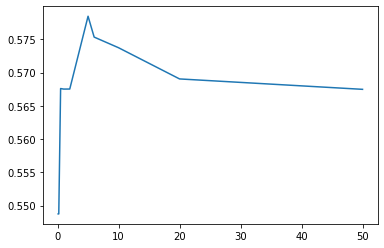

In [20]:
plt.plot(c_list, mean_accuracy)

               precision    recall  f1-score   support

       tauniv       0.52      0.12      0.19        95
õigeksmõistev       0.56      0.91      0.69       116

    micro avg       0.55      0.55      0.55       211
    macro avg       0.54      0.51      0.44       211
 weighted avg       0.54      0.55      0.47       211

Logistilise regressiooni mudeli ennustustäpsus: 55.45%
Normaliseerimata veamaatriks


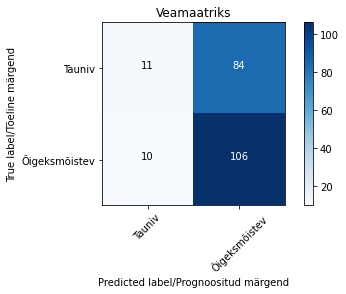

In [21]:
# Vektoriseerimine ja TF-IDF rakendamine
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

pipe = Pipeline([('vect', CountVectorizer()),#tokenizer = lemmatize_with_estnltk, stop_words = stopsõnad_uus)),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression())])

# Mudeli sobitamine
model = pipe.fit(X_train, y_train)

# Prognoosimine
prediction = model.predict(X_test)
print(classification_report(y_test, prediction))
print("Logistilise regressiooni mudeli ennustustäpsus: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

cm = confusion_matrix(y_test, prediction)

plot_confusion_matrix(cm, classes=['Tauniv', 'Õigeksmõistev'])